In [1]:
#Imports
import sys,os
os.environ['MKL_NUM_THREADS'] = '4' # set number of MKL threads to run in parallel
from quspin.operators import hamiltonian,quantum_operator
from quspin.basis import spin_basis_1d
from numpy.random import uniform,seed
from joblib import delayed,Parallel
from itertools import combinations
from functools import partial
import numpy as np
import gc
import pickle
from time import time
from quspin.tools.measurements import diag_ensemble
from quspin.tools.evolution import ED_state_vs_time
import matplotlib.pyplot as plt
timestamp = time()

In [2]:
# Specify the size of the matrix
L = 8  # Replace 5 with your desired value

# Generate a random L x L matrix
RM1 = np.random.rand(2**L, 2**L)
RM2 = np.random.rand(2*L,2*L)


In [3]:
timestamp = time()
np.linalg.eigh(RM1)

x = time()-timestamp

timestamp = time()
np.linalg.eigh(RM2)

y = time()-timestamp

print(x/y)

1299.018711018711


In [4]:
import numpy as np

A = np.array([[1, 2],
              [3, 4]])

def single_block(k):
    e = -2*J*np.cos(k)-2*h
    d = 2*J*np.sin(k)
    A = np.array([[e,d],[d,-e]])
    return A




In [181]:
import scipy
J = 1
h = 0
L = 8
k = np.array([np.pi * (2*n - 1) / L for n in range(-L//2 + 1, L//2 + 1)])
x = [single_block(ki) for ki in k]
H = scipy.linalg.block_diag(*x)

In [ ]:
from itertools import product
evals, evecs = np.linalg.eigh(H)  # evals: 2L eigenvalues

states = list(product([0, 1], repeat=L))  # all occupation patterns
E_many = np.array([sum(eps[i] * occ[i] for i in range(L)) for occ in states])

H_many = np.diag(E_many)  # diagonal many-body Hamiltonian


In [196]:
from itertools import product
import numpy as np

evals, _ = np.linalg.eigh(H)  # H is 2L x 2L

L = len(evals) // 2
eps = evals[L:]  # positive eigenvalues

states = list(product([0, 1], repeat=L))  # 2^L states
E_many = np.array([sum(eps[i] * occ[i] for i in range(L)) for occ in states])
H_many = np.diag(E_many)



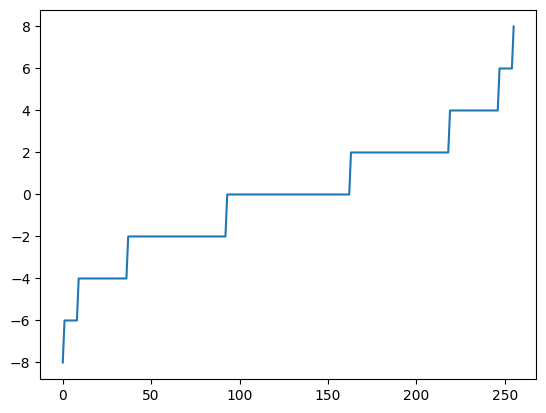

In [200]:
plt.plot(np.sort(E_many)-8)

In [ ]:
import numpy as np
from scipy.linalg import block_diag
from itertools import product

J = 1
h = 0
L = 8

# Periodic BC: odd parity sector
k = np.array([2 * np.pi * n / L for n in range(L)])

def single_block(k):
    e = -2 * h - 2 * J * np.cos(k)
    d = 2 * J * np.sin(k)
    return np.array([[e, d], [d, -e]])

blocks = [single_block(ki) for ki in k]
H = block_diag(*blocks)

# Diagonalize H
evals, _ = np.linalg.eigh(H)

# Keep positive eigenvalues (L of them) — they correspond to Bogoliubov modes
eps = evals[L:]

# Build many-body energies from occupations of Bogoliubov modes
states = list(product([0, 1], repeat=L))
E_many = np.array([sum(eps[i] * occ[i] for i in range(L)) for occ in states])
H_many = np.sort(E_many)


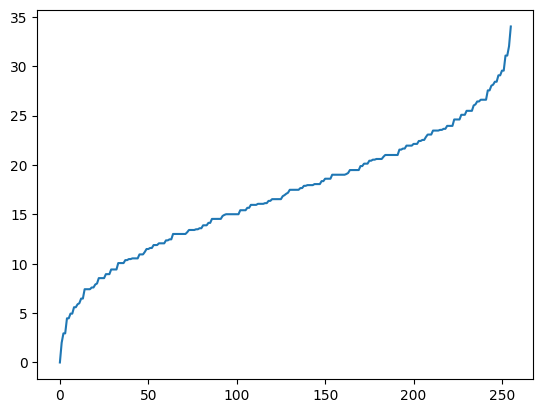

In [217]:
plt.plot(np.sort(E_many))


In [225]:
import numpy as np
from scipy.linalg import block_diag
from itertools import product

J = 1
h = 0
L = 8

# Periodic BCs (odd parity sector)
k = np.array([(2 * np.pi * n-1) / L for n in range(1,L+1)])

def single_block(k):
    e = -2 * h - 2 * J * np.cos(k)
    d = 2 * J * np.sin(k)
    return np.array([[e, d], [d, -e]])

# Construct block-diagonal Hamiltonian
blocks = [single_block(ki) for ki in k]
H = block_diag(*blocks)

# Diagonalize H
evals, _ = np.linalg.eigh(H)

# Sort and extract positive energies (Bogoliubov mode energies)
evals = np.sort(evals)
eps = evals[L:]  # positive-energy quasiparticles
E0 = -0.5 * np.sum(eps)  # ground state energy (vacuum)

# Generate all 2^L occupation states
states = list(product([0, 1], repeat=L))

# Build full many-body spectrum
E_many = np.array([E0 + sum(eps[i] * occ[i] for i in range(L)) for occ in states])
H_many = np.sort(E_many)


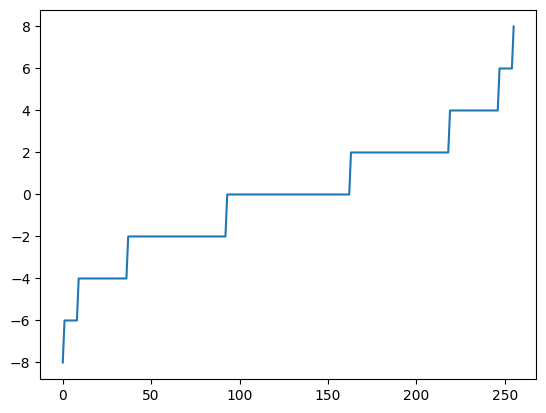

In [226]:
plt.plot(np.sort(E_many))

In [222]:
evals, _ = np.linalg.eigh(H)

# Remove tiny numerical zero eigenvalues if present (safe cutoff)
evals = np.real_if_close(evals)
evals = np.sort(evals)

# Assuming particle-hole symmetry: take positive eigenvalues
eps = evals[evals > 1e-10]  # keep only strictly positive

# Ground state energy (vacuum energy)
E0 = -0.5 * np.sum(eps)

# Generate all 2^L configurations
from itertools import product
states = list(product([0, 1], repeat=len(eps)))

# Build many-body spectrum
E_many = np.array([E0 + sum(occ[i] * eps[i] for i in range(len(eps))) for occ in states])
H_many = np.sort(E_many)


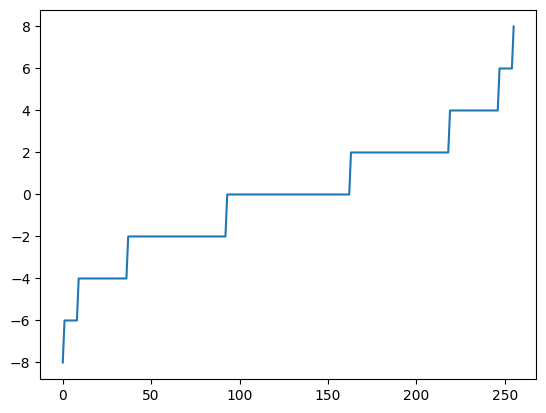

In [227]:
import numpy as np
from scipy.linalg import block_diag
from itertools import product

J = 1
h = 0
L = 8
k_vals = np.array([2 * np.pi * n / L for n in range(L)])
blocks = [single_block(k) for k in k_vals]
H_bdg = block_diag(*blocks)

# Diagonalize H
evals, _ = np.linalg.eigh(H_bdg)

# Sort to extract positive modes
evals = np.sort(np.real_if_close(evals))
eps = evals[evals > 1e-10]  # only positive modes
E0 = -0.5 * np.sum(eps)  # vacuum energy

# All 2^L configurations over L positive-energy modes
states = list(product([0, 1], repeat=L))
E_many = np.array([E0 + sum(eps[i] * occ[i] for i in range(L)) for occ in states])
H_many = np.sort(E_many)
plt.plot(H_many)




In [231]:
# --- Imports ---
import numpy as np
from scipy.linalg import block_diag
from itertools import product
from quspin.operators import quantum_operator
from quspin.basis import spin_basis_1d

# --- Parameters ---
L = 8
J = 1
h = 0

# --- QuSpin: Full spin Hamiltonian ---
basis = spin_basis_1d(L, pauli=-1, pblock=1)  # pblock=1 → odd fermion parity
J_list = [[-J, i, (i+1)%L] for i in range(L)]  # periodic
h_list = [[-h, i] for i in range(L)]

static = [["xx", J_list], ["z", h_list]]
H_spin = quantum_operator({"static": static}, basis=basis).tohamiltonian()
E_spin = np.sort(np.linalg.eigvalsh(H_spin.todense()))


Hermiticity check passed!
Symmetry checks passed!


In [232]:
# --- BdG construction ---
def single_block(k):
    e = -2 * h - 2 * J * np.cos(k)
    d = 2 * J * np.sin(k)
    return np.array([[e, d], [d, -e]])

k_vals = np.array([2 * np.pi * n / L for n in range(L)])  # PBC → odd fermion parity
blocks = [single_block(k) for k in k_vals]
H_bdg = block_diag(*blocks)

# Diagonalize
evals, _ = np.linalg.eigh(H_bdg)
evals = np.sort(np.real_if_close(evals))
eps = evals[evals > 1e-10]  # only positive eigenvalues
E0 = -0.5 * np.sum(eps)

# Build many-body energies
states = list(product([0, 1], repeat=L))
E_many = np.array([E0 + sum(eps[i] * occ[i] for i in range(L)) for occ in states])
E_bdg = np.sort(E_many)


In [233]:
# --- Compare ---
print(np.allclose(E_bdg, E_spin, atol=1e-10))  # should be True
print("Max error:", np.max(np.abs(E_bdg - E_spin)))


ValueError: operands could not be broadcast together with shapes (256,) (136,) 

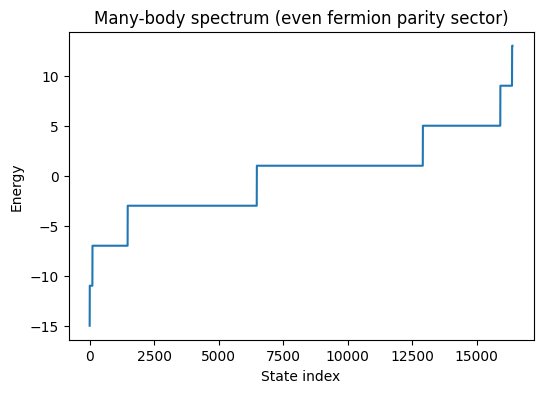

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product

# Parameters
J = -1
h = 0
L = 15

# Define single-particle BdG block for each momentum
def single_block(k):
    e = -2 * h - 2 * J * np.cos(k)
    d = 2 * J * np.sin(k)
    return np.array([[e, d], [d, -e]])

# Anti-periodic BCs (even fermion parity): k = (2n-1)π / L
k_vals = np.array([(2*n - 1) * np.pi / L for n in range(1, L+1)])

# Build full 2L × 2L BdG Hamiltonian
blocks = [single_block(k) for k in k_vals]
H_bdg = block_diag(*blocks)

# Diagonalize BdG Hamiltonian
evals, _ = np.linalg.eigh(H_bdg)
evals = np.sort(np.real_if_close(evals))
eps = evals[evals > 1e-10]  # positive quasiparticle energies
E0 = -0.5 * np.sum(eps)     # ground state (vacuum) energy

# Generate many-body states with even number of quasiparticles
states = list(product([0, 1], repeat=L))
states = [s for s in states if sum(s) % 2 == 0]

# Build many-body spectrum
E_many = np.array([E0 + sum(eps[i] * s[i] for i in range(L)) for s in states])
H_many = np.sort(E_many)

# Plot
plt.figure(figsize=(6,4))
plt.plot(H_many)
plt.title("Many-body spectrum (even fermion parity sector)")
plt.xlabel("State index")
plt.ylabel("Energy")

plt.show()


In [244]:
eps

array([1.14213916, 1.14213916, 1.86259665, 1.86259665, 2.55553003,
       2.55553003, 2.94881639, 2.94881639])

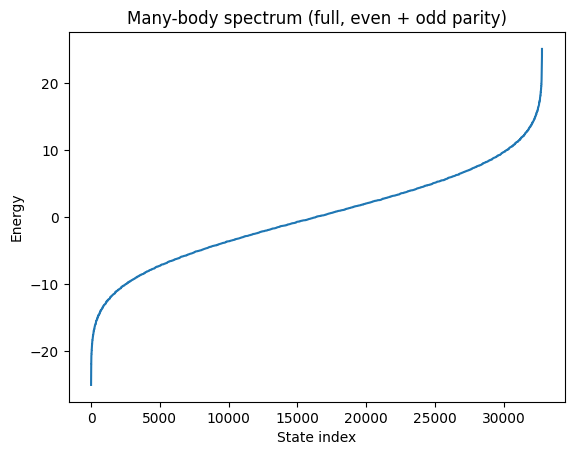

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product

# Parameters
J = -1
h = 1.5
L = 15

def single_block(k):
    e = -2 * h - 2 * J * np.cos(k)
    d = 2 * J * np.sin(k)
    return np.array([[e, d], [d, -e]])

def build_spectrum(k_vals, parity):  # parity: 0 = even, 1 = odd
    blocks = [single_block(k) for k in k_vals]
    H_bdg = block_diag(*blocks)
    evals, _ = np.linalg.eigh(H_bdg)
    evals = np.sort(np.real_if_close(evals))
    eps = evals[evals > 1e-10]
    E0 = -0.5 * np.sum(eps)
    states = list(product([0, 1], repeat=L))
    states = [s for s in states if sum(s) % 2 == parity]
    E_many = np.array([E0 + sum(eps[i] * s[i] for i in range(L)) for s in states])
    return np.sort(E_many)

# Even parity sector (anti-periodic BC)
k_even = np.array([(2*n - 1) * np.pi / L for n in range(1, L+1)])
E_even = build_spectrum(k_even, parity=0)

# Odd parity sector (periodic BC)
k_odd = np.array([2 * np.pi * n / L for n in range(L)])
E_odd = build_spectrum(k_odd, parity=1)

# Full spectrum
E_full = np.sort(np.concatenate((E_even, E_odd)))

# Plot
#plt.figure(figsize=(6, 4))
plt.plot(E_full)
plt.title("Many-body spectrum (full, even + odd parity)")
plt.xlabel("State index")
plt.ylabel("Energy")

plt.show()


In [8]:
import numpy as np
from scipy.linalg import eigh
from itertools import product
import matplotlib.pyplot as plt

J =1
h = 1
L = 50

# Build BdG Hamiltonian in real space
A = np.zeros((L, L))
B = np.zeros((L, L))

for j in range(L):
    A[j, j] = 2 * h
for j in range(L-1):  # PBC:  wraparound
    A[j, (j+1)%L] = A[(j+1)%L, j] = -J
    B[j, (j+1)%L] = -J
    B[(j+1)%L, j] = J
# B[L-1,0] = J
# B[0,L-1] = -B[L-1,0]
# A[0,L-1]= A[L-1,0] = J

# Build full 2L x 2L BdG matrix
H_bdg = np.block([[A, B], [-B, -A]])

# Diagonalize
evals, V = eigh(H_bdg)
eps = np.sort(np.real_if_close(evals))[L:]  # positive-energy modes
E0 = - 1/2 *np.sum(eps)

# # Build many-body spectrum (all states)
# states = list(product([0, 1], repeat=L))
# states = [s for s in states if sum(s) % 2 == 0]

# E_many = np.array([E0 + sum(eps[i] * s[i] for i in range(L)) for s in states])
# H_many = np.sort(E_many)

# Plot
# plt.plot(H_many)
# plt.title("TFIM Many-Body Spectrum (Open BC)")
# plt.xlabel("State index")
# plt.ylabel("Energy")
# plt.show()


np.float64(0.12441449536280302)

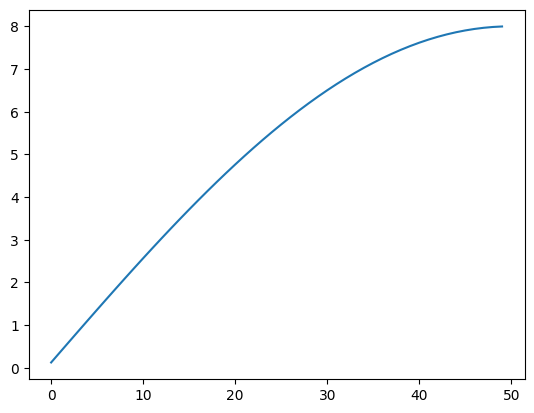

In [7]:
positive_E_many = 2*evals[evals > 0]
plt.plot(np.sort(positive_E_many))

min(positive_E_many)

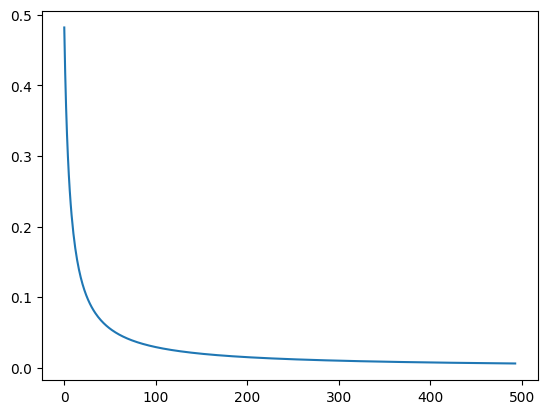

In [11]:
J =1
h = 1
data =[]
for L in range(6,500):

    # Build BdG Hamiltonian in real space
    A = np.zeros((L, L))
    B = np.zeros((L, L))

    for j in range(L):
        A[j, j] = 2 * h
    for j in range(L-1):  # PBC:  wraparound
        A[j, (j+1)%L] = A[(j+1)%L, j] = -J
        B[j, (j+1)%L] = -J
        B[(j+1)%L, j] = J
    # B[L-1,0] = J
# B[0,L-1] = -B[L-1,0]
# A[0,L-1]= A[L-1,0] = J

    # Build full 2L x 2L BdG matrix
    H_bdg = np.block([[A, B], [-B, -A]])

    # Diagonalize
    evals, V = eigh(H_bdg)
  # positive-energy modes
    evals = np.sort(evals[evals>0])
    data.append(evals[0])
plt.plot(data)

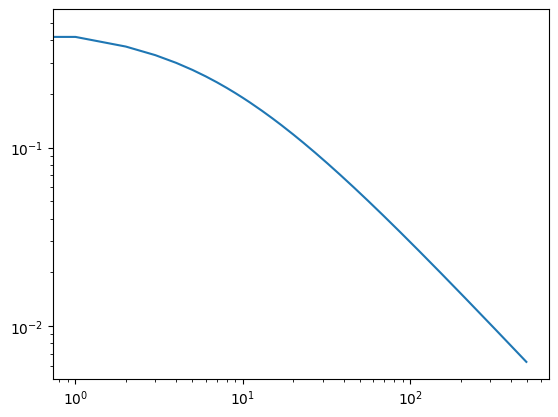

In [13]:
plt.plot(data)
plt.yscale("log")
plt.xscale("log")

In [326]:
def sigma_xx(j, G, L):
    # indices
    cj = j
    cj1 = j + 1
    cjd = L + j
    cj1d = L + j + 1
    
    term1 = G[cjd, cj1d]     # ⟨ c_j† c_{j+1}† ⟩
    term2 = G[cjd, cj1]      # ⟨ c_j† c_{j+1} ⟩
    term3 = -G[cj, cj1d]      # ⟨ c_j c_{j+1}† ⟩
    term4 = -G[cj, cj1]       # ⟨ c_j c_{j+1} ⟩
    
    return term1 + term2 + term3 + term4


In [330]:
# After: 
evals, evecs = np.linalg.eigh(H_bdg)
U_minus = evecs[:, :L]  # L negative energy modes
G = U_minus @ U_minus.T.conj()  # correlation matrix ⟨Ψ Ψ†⟩

# Compute σ^x_j σ^x_{j+1} for j = 0 to L-2
xx_vals = [np.real(sigma_xx(j, G, L)) for j in range(L -1)]
len(xx_vals)

19

In [408]:
import numpy as np
from scipy.linalg import eigh
from itertools import product
import matplotlib.pyplot as plt

J =-1
h_i = np.linspace(0,2,100)
L = 20
H_i = []
for h in h_i:
    # Build BdG Hamiltonian in real space
    A = np.zeros((L, L))
    B = np.zeros((L, L))

    for j in range(L):
        A[j, j] = -2 * h
    for j in range(L - 1):  # OBC: no wraparound
        A[j, j+1] = A[j+1, j] = -J
        B[j, j+1] = -J
        B[j+1, j] = J

    # Build full 2L x 2L BdG matrix
    H_bdg = np.block([[A, B], [-B, -A]])
    H_i.append(H_bdg)


In [409]:
xx_i = []
for H in H_i:
    # After: 
    evals, evecs = np.linalg.eigh(H)
    U_minus = evecs[:, :L]  # L negative energy modes
    G = U_minus @ U_minus.T.conj()  # correlation matrix ⟨Ψ Ψ†⟩
    print(np.shape(G))
# Compute σ^x_j σ^x_{j+1} for j = 0 to L-2
    xx_vals = [np.real(sigma_xx(j, G, L)) for j in range(L -1)]
    xx_i.append(1/4+xx_vals[4]/4)

(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)
(40, 40)


(0.0, 2.0)

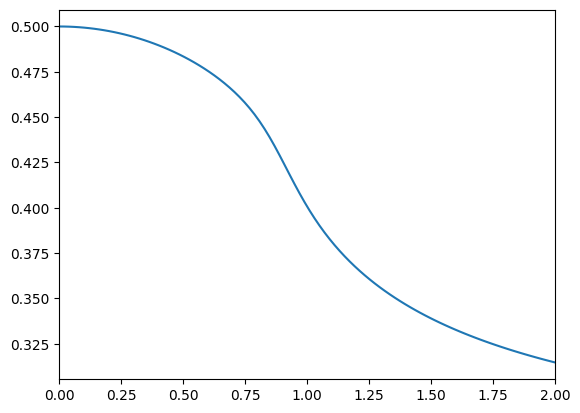

In [410]:
plt.plot(h_i,xx_i)
plt.xlim(h_i[0],h_i[-1])

(0.0, 2.0)

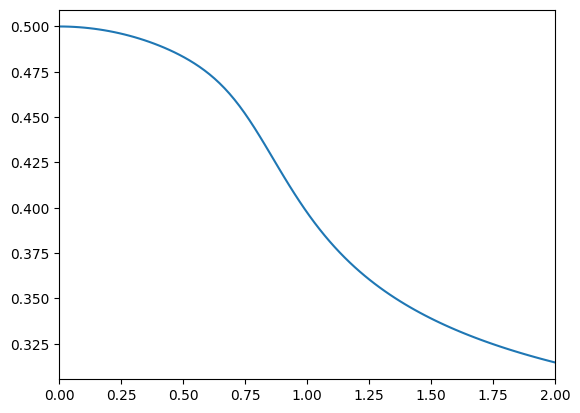

In [374]:
from scipy.linalg import eigh
import numpy as np

def sigma_xx_ij(i, j, Gamma):
    if i == j:
        return 1.0
    elif j < i:
        return sigma_xx_ij(j, i, Gamma)

    # Build Majorana indices: gamma_{2k}, gamma_{2k+1} = A_k, B_k
    indices = []
    indices.append(2*i)  # A_i
    for k in range(i+1, j):
        indices.append(2*k + 1)  # B_k
        indices.append(2*k)      # A_k
    indices.append(2*j)  # A_j

    # Extract antisymmetric submatrix
    Gsub = Gamma[np.ix_(indices, indices)]

    return np.sqrt(np.linalg.det(Gsub)) # result is real in ground state


THIS FOLLOWING IS FOR ADIABATIC TIME EVOLUTION1!!!!!

In [301]:
import numpy as np
from scipy.linalg import eigh
from itertools import product
import matplotlib.pyplot as plt

J =1
L = 500
tau = 10
N_steps = 1000
t,dt= np.linspace(0,tau,N_steps,retstep=True)

def H_bdg(h,L,J=1):

    # Build BdG Hamiltonian in real space
    A = np.zeros((L, L))
    B = np.zeros((L, L))

    for j in range(L):
        A[j, j] = 2 * h
    for j in range(L-1):  # PBC:  wraparound
        A[j, (j+1)%L] = A[(j+1)%L, j] = -J
        B[j, (j+1)%L] = -J
        B[(j+1)%L, j] = J
    # B[L-1,0] = J
    # B[0,L-1] = -B[L-1,0]
    # A[0,L-1]= A[L-1,0] = J

    # Build full 2L x 2L BdG matrix
    H_bdg = np.block([[A, B], [-B, -A]])
    return H_bdg

def h_t(t, tau, h0, hf):
    return h0 + (hf - h0) * (t / tau)


H_bdg_t = [H_bdg(h_t(ti, tau, 1000,0), L) for ti in t]


_, V = np.linalg.eigh(H_bdg_t[0])
GS = V[:, :L]

# Diagonalize
# evals, V = eigh(H_bdg)
# eps = np.sort(np.real_if_close(evals))[L:]  # positive-energy modes
# E0 = - 1/2 *np.sum(eps)

# # Build many-body spectrum (all states)
# states = list(product([0, 1], repeat=L))
# states = [s for s in states if sum(s) % 2 == 0]




In [302]:
pt = np.asarray(GS, dtype=np.complex128)
T = H_bdg_t
dat1 = [pt.copy()]

for i in range(len(T)-1):
    pt += 2 * T[i] @ pt * dt / (1j)
    pt /= np.linalg.norm(pt)
    dat1.append(pt.copy())


In [303]:
np.shape(dat1[3])

(1000, 500)

In [304]:
def sigma_xx( j,psi, L):
    G = Gi(psi)
    # indices
    cj = j
    cj1 = j + 1
    cjd = L + j
    cj1d = L + j + 1
    
    term1 = G[cjd, cj1d]     # ⟨ c_j† c_{j+1}† ⟩
    term2 = G[cjd, cj1]      # ⟨ c_j† c_{j+1} ⟩
    term3 = -G[cj, cj1d]      # ⟨ c_j c_{j+1}† ⟩
    term4 = -G[cj, cj1]       # ⟨ c_j c_{j+1} ⟩
    
    return term1 + term2 + term3 + term4
def Gi(psi):
    return psi @ psi.T.conj() 

sigma_xx(4,GS,L)

np.float64(-0.0005000000624997405)

In [305]:
sigma_xx_t = []
for ti in range(len(t)):
    x = sigma_xx(L//2,dat1[ti],L)
    sigma_xx_t.append(1/2+x/2)
sigma_xx_t = np.array(sigma_xx_t)


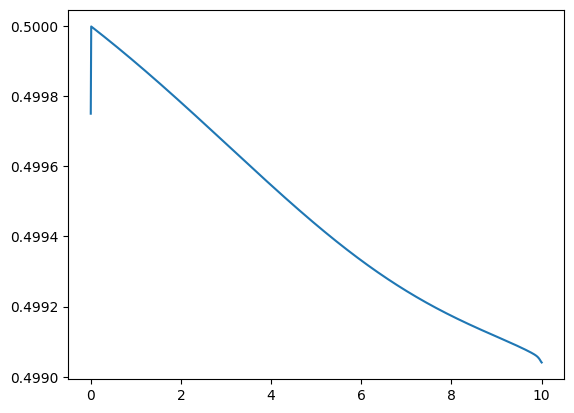

In [306]:
plt.plot(t,sigma_xx_t)
#plt.hlines(np.sqrt(1/tau),t[0],t[-1])

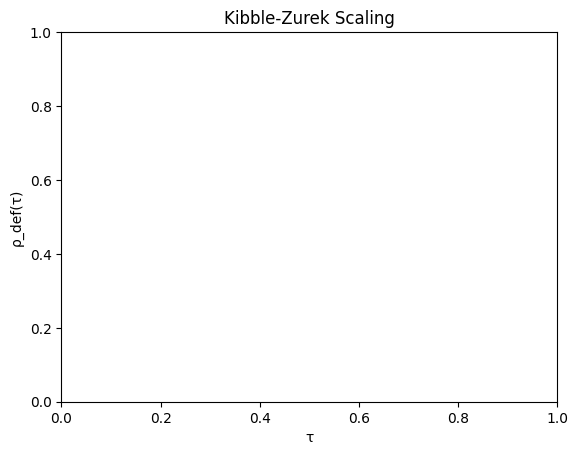

In [336]:
import numpy as np
import matplotlib.pyplot as plt

J = 1
L = 500
taus = [5, 10, 20, 40, 80, 160]
hi = 10

def h_t(t, tau, h0, hf):
    return h0 + (hf - h0) * (t / tau)

def H_bdg(h, L, J=1):
    A = np.zeros((L, L))
    B = np.zeros((L, L))
    for j in range(L):
        A[j, j] = 2 * h
    for j in range(L-1):
        A[j, j+1] = A[j+1, j] = -J
        B[j, j+1] = -J
        B[j+1, j] = J
    return np.block([[A, B], [-B, -A]])

def sigma_xx(j, G, L):
    cj = j
    cj1 = j + 1
    cjd = L + j
    cj1d = L + j + 1
    term1 = G[cjd, cj1d]
    term2 = G[cjd, cj1]
    term3 = -G[cj, cj1d]
    term4 = -G[cj, cj1]
    return term1 + term2 + term3 + term4

rho_defs = []

for tau in taus:
    N_steps = 100
    t_vals, dt = np.linspace(0, tau, N_steps, retstep=True)
    H0 = H_bdg(hi, L)
    _, evecs = np.linalg.eigh(H0)
    U = evecs[:, :L]  # initial negative-energy modes
    U = np.asarray(U, dtype=np.complex128)

    for t in t_vals:
        H = H_bdg(h_t(t, tau, hi, 0), L)
        # U += -2j * H @ U * dt
        I = np.eye(2*L)
        A = I + 0.5j * dt * H
        B = I - 0.5j * dt * H
        U = np.linalg.solve(A, B @ U)

        # Optional stabilization:
        # U, _ = np.linalg.qr(U)

    G = U @ U.conj().T
    xx_vals = [np.real(sigma_xx(j, G, L)) for j in range(L - 1)]
    rho_def = 0.5 * (1 + np.mean(xx_vals))
    rho_defs.append(rho_def)

#plt.loglog(taus, rho_defs, 'o-')
plt.xlabel("τ")
plt.ylabel("ρ_def(τ)")
plt.title("Kibble-Zurek Scaling")
#plt.grid(True, which="both", ls="--")
plt.show()


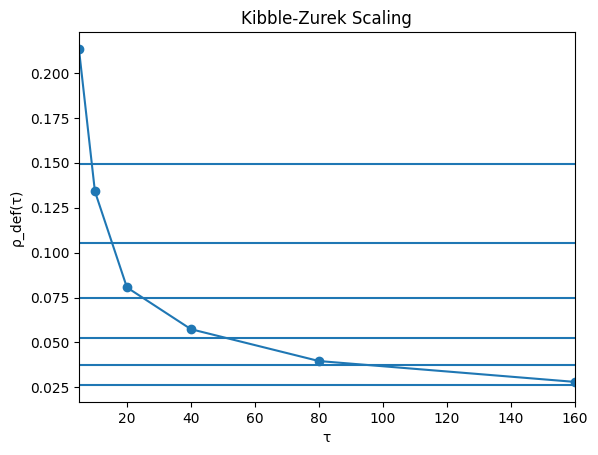

In [343]:

plt.plot(taus, np.array(rho_defs), 'o-')
plt.xlabel("τ")
plt.ylabel("ρ_def(τ)")
plt.title("Kibble-Zurek Scaling")
plt.hlines(x/3,0,10000)


plt.xlim(taus[0],taus[-1])
plt.show()


In [334]:
x = np.sqrt(1/np.array(taus))
x

array([0.4472136 , 0.31622777, 0.2236068 , 0.15811388, 0.1118034 ,
       0.07905694])